## P&O ISSP: Brain-computer interface voor sturing van een directionele akoestische zoom

In this notebook, we will start building a basic deep learning implementation for classifying which two of the Stimuli was attended to, when given EEG and both Stimuli as input. 


One of the ways to process the EEG data is to find specific patterns in the signal. Based on the presence or absence of these patterns we will decide where is the auditory attention. But handcrafting these pattern might be difficult, so we will use convolutional neural network to learn filters which can detect those patterns.

The implementation will be in mulitple phases. First, we will get more familiar with keras and the deep learning framework by mimicking the linear regression-based network, but then in a non-linear context. Once we have implemented this, we can start playing with the deep learning architectures and add some blocks, see what different training schemes do, etc...

Once we have a working model, we can start to play with the data and see if we can improve the performance. The basic model will transform the EEG to a space where it has to resemble the envelope, and then we will compare performance by calcualtion the correlation between this represenation and both envelopes. instead of only transforming the EEG, we can try to transform the envelopes as well. In this way, both EEG and envelopes get transformed to a common space, and we can compare how similar they are in this latent space. This gives the model more degrees of freedom, to find a representation that is good for both the EEG and the envelopes.



**Note**: If keras is  not already installed, execute: !pip install keras

In [1]:
# Load required libraries
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, Activation, Lambda, GlobalAveragePooling1D
from keras import regularizers
import numpy as np
import tensorflow as tf
import os
from keras.models import Model
from keras.layers import Input, Conv1D, Dense, Activation, Dot, Flatten, Reshape, MaxPooling1D, Dropout
from keras.optimizers import Adam
from keras.backend import l2_normalize
from sklearn.model_selection import train_test_split

from keras.callbacks import EarlyStopping
from typing import Sequence, Union
import pathlib
import mne
import random

from IPython.display import clear_output
import matplotlib.pyplot as plt

In [2]:
class DataGenerator:
    """Generate data for the Match/Mismatch task."""

    def __init__(
        self,
        files: Sequence[Union[str, pathlib.Path]],
        base_path: str = os.getcwd() + "/data/train_cnn",
        eeg_base_path: str = os.getcwd() + "/data/eeg",
        time_window: int = 60 * 10
    ):
        """Initialize the DataGenerator.

        Parameters
        ----------
        files: Sequence[Union[str, pathlib.Path]]
            Files to load.
        """
        self.files = files
        self.base_path = base_path
        self.eeg_base_path = eeg_base_path
        self.time_window = time_window

    def __len__(self):
        return len(self.files)

    def __getitem__(self, recording_index):
        eeg_filename = self.files[recording_index]
        eeg_data = np.load(os.path.join(self.eeg_base_path, eeg_filename))

        attended_filename = str(eeg_data["stimulus_attended"]).replace(".wav", "") + ".npy"
        unattended_filename = str(eeg_data["stimulus_unattended"]).replace(".wav", "") + ".npy"
        
#         eeg_preprocessed = np.load(os.path.join(self.base_path, eeg_filename.replace(".npz", ".npy")))
#         attended_preprocessed = np.load(os.path.join(self.base_path, attended_filename))
#         unattended_preprocessed = np.load(os.path.join(self.base_path, unattended_filename))
        
        eeg_filepath = os.path.join(self.base_path, eeg_filename.replace(".npz", ".npy"))
        attended_filepath = os.path.join(self.base_path, attended_filename)
        unattended_filepath = os.path.join(self.base_path, unattended_filename)

        if not os.path.exists(eeg_filepath) or not os.path.exists(attended_filepath) or not os.path.exists(unattended_filepath):
            return None, None, None

        eeg_preprocessed = np.load(eeg_filepath)
        attended_preprocessed = np.load(attended_filepath)
        unattended_preprocessed = np.load(unattended_filepath)
    
        min_data_len = min(eeg_preprocessed.shape[0], attended_preprocessed.shape[0], unattended_preprocessed.shape[0])
        new_data_length = (min_data_len // self.time_window) * self.time_window
        
        eeg_preprocessed = eeg_preprocessed[:new_data_length]
        attended_preprocessed = attended_preprocessed[:new_data_length]
        unattended_preprocessed = unattended_preprocessed[:new_data_length]

        # Reshape the attended and unattended envelopes to have an extra dimension
        attended_preprocessed = attended_preprocessed.reshape(-1, self.time_window, 1)
        unattended_preprocessed = unattended_preprocessed.reshape(-1, self.time_window, 1)

        # Reshape the EEG data
        eeg_preprocessed = eeg_preprocessed.reshape(-1, self.time_window, 64)
        
        split_index = int(eeg_preprocessed.shape[0] * 0.8)
        
        eeg_train, eeg_val = np.split(eeg_preprocessed, [split_index], axis=0)
        attended_train, attended_val = np.split(attended_preprocessed, [split_index], axis=0)
        unattended_train, unattended_val = np.split(unattended_preprocessed, [split_index], axis=0)
#         print("================")
#         print(eeg_train.shape)
#         print(eeg_val.shape)
#         print(attended_train.shape)
#         print(attended_val.shape)
#         print(unattended_train.shape)
#         print(unattended_val.shape)
#         print("================")
        return eeg_train, attended_train, unattended_train, eeg_val, attended_val, unattended_val

    def __call__(self):
        for idx in range(self.__len__()):
            yield self.__getitem__(idx)

            if idx == self.__len__() - 1:
                self.on_epoch_end()

    def on_epoch_end(self):
        random.shuffle(self.files)  
        

def batch_equalizer(eeg, env_1, env_2, labels):
    # present each of the eeg segments twice, where the envelopes, and thus the labels 
    # are swapped around. EEG presented in small segments [bs, window_length, 64]
    return np.concatenate([eeg, eeg], axis=0), np.concatenate([env_1, env_2], axis=0), np.concatenate([ env_2, env_1], axis=0), np.concatenate([labels, (labels+1)%2], axis=0)

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len (physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


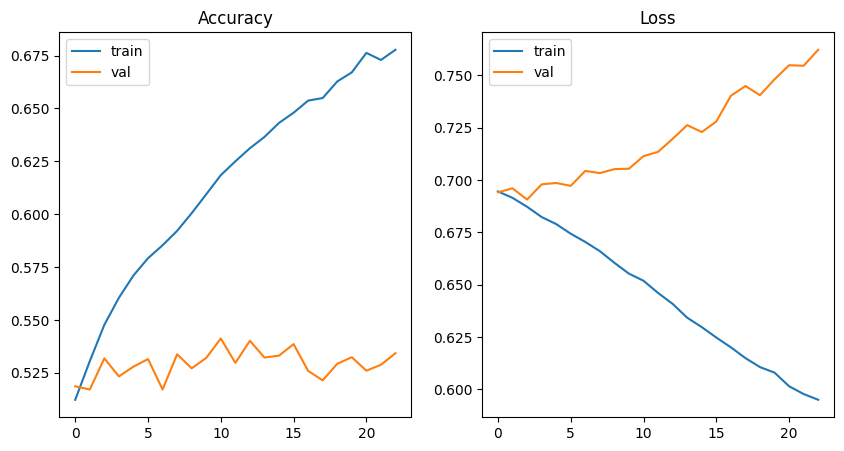

Epoch 23/50
Training loss: 59.51%
Training accuracy: 67.77%
Validation loss: 76.23%
Validation accuracy: 53.43%
Early stopping triggered


In [4]:
data_folder = os.getcwd() + '/data/eeg'
all_files = [f for f in os.listdir(data_folder) if f.endswith('.npz')]

data_generator = DataGenerator(all_files)

# BUILDING THE MODEL
time_window = data_generator.time_window
# early_stopping = EarlyStopping(monitor='val_loss', patience=5)

eeg = Input(shape=(time_window, 64))
env1 = Input(shape=(time_window, 1))
env2 = Input(shape=(time_window, 1))

conv1 = Conv1D(filters=16, kernel_size=16, activation='relu', padding='causal')(eeg)

cos_sim1 = tf.keras.layers.Dot(axes=(1, 1), normalize=True)([conv1, env1])
cos_sim2 = tf.keras.layers.Dot(axes=(1, 1), normalize=True)([conv1, env2])

# Classification
out1 = Dense(1, activation="sigmoid")(tf.keras.layers.Flatten()(tf.keras.layers.Concatenate()([cos_sim1, cos_sim2])))

# 1 output per batch
out = tf.keras.layers.Reshape([1], name="output_name")(out1)
model = tf.keras.Model(inputs=[eeg, env1, env2], outputs=[out])

# Compile the model
# Use legacy adam optimizer
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.1), loss='binary_crossentropy', metrics=['accuracy'])

# TRAINING THE MODEL
# Set the number of epochs
num_epochs = 50

# Initialize variables for early stopping
best_val_loss = float('inf')
patience = 20
counter = 0
train_loss_arr = []
train_acc_arr = []
val_loss_arr = []
val_acc_arr = []
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    
    # TRAINING THE MODEL
    train_loss = 0
    train_acc = 0
    train_steps = 0
    
    val_loss = 0
    val_acc = 0
    
    
    for data in data_generator():
#         print(len(data))
        try:
            eeg_train, env1_train, env2_train, eeg_val, env1_val, env2_val = data
            # Train the model on the loaded data
            if eeg_train is not None:
                eeg_train, env1_train, env2_train, labels_train = batch_equalizer(eeg_train, env1_train, env2_train, np.ones(eeg_train.shape[0]))
                loss, accuracy = model.train_on_batch([eeg_train, env1_train, env2_train], labels_train)
                train_loss += loss
                train_acc += accuracy

                eeg_val, env1_val, env2_val, labels_val = batch_equalizer(eeg_val, env1_val, env2_val, np.ones(eeg_val.shape[0]))
                loss, accuracy = model.evaluate([eeg_val, env1_val, env2_val], labels_val, verbose=0)
                val_loss += loss
                val_acc += accuracy
                
                train_steps += 1
        except:
            pass
    
    
    train_loss /= train_steps
    train_acc /= train_steps
    val_loss = val_loss / train_steps
    val_acc = val_acc / train_steps
    
    train_loss_arr.append(train_loss)
    train_acc_arr.append(train_acc)
    val_loss_arr.append(val_loss)
    val_acc_arr.append(val_acc)
    
    clear_output(wait=True)
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].set_title('Accuracy')
    axs[0].plot(train_acc_arr, label='train')
    axs[0].plot(val_acc_arr, label='val')
    axs[0].legend()
    axs[1].set_title('Loss')
    axs[1].plot(train_loss_arr, label='train')
    axs[1].plot(val_loss_arr, label='val')
    axs[1].legend()
    plt.show()    
    
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f'Training loss: {train_loss * 100:.2f}%')
    print(f'Training accuracy: {train_acc * 100:.2f}%')
    print(f"Validation loss: {val_loss * 100:.2f}%")
    print(f"Validation accuracy: {val_acc * 100:.2f}%")
    

    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
    else:
        counter += 1

    if counter >= patience:
        print("Early stopping triggered")
        break

In [10]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 600, 64)]    0           []                               
                                                                                                  
 conv1d_3 (Conv1D)              (None, 600, 1)       1025        ['input_10[0][0]']               
                                                                                                  
 input_11 (InputLayer)          [(None, 600, 1)]     0           []                               
                                                                                                  
 input_12 (InputLayer)          [(None, 600, 1)]     0           []                               
                                                                                            

In [11]:
# TESTING THE MODEL

# Initialize variables for accumulating test results
test_loss = 0
test_accuracy = 0
num_test_batches = 0

# Iterate through the test generator
for eeg, env1, env2 in val_data_generator():
    # Test the model on the current batch
    if eeg is not None:
        eeg, env1, env2, labels = batch_equalizer(eeg, env1, env2, np.ones(eeg.shape[0]))
        test_metrics = model.test_on_batch([eeg, env1, env2], labels)
        test_loss += test_metrics[0]
        test_accuracy += test_metrics[1]
        num_test_batches += 1
        print("Test loss: {:.4f}, Test accuracy: {:.4f}".format(test_metrics[0], test_metrics[1]))

# Calculate the average test loss and accuracy
avg_test_loss = test_loss / num_test_batches
avg_test_accuracy = test_accuracy / num_test_batches

print("Test loss: {:.4f}, Test accuracy: {:.4f}".format(avg_test_loss, avg_test_accuracy))


Test loss: 0.7060, Test accuracy: 0.5000
Test loss: 0.7035, Test accuracy: 0.5380
Test loss: 0.6976, Test accuracy: 0.5312
Test loss: 0.6476, Test accuracy: 0.6443
Test loss: 0.6814, Test accuracy: 0.6023
Test loss: 0.6421, Test accuracy: 0.6237
Test loss: 0.6384, Test accuracy: 0.6307
Test loss: 0.6582, Test accuracy: 0.6250
Test loss: 0.6733, Test accuracy: 0.5930
Test loss: 0.7478, Test accuracy: 0.5523
Test loss: 0.6924, Test accuracy: 0.5833
Test loss: 0.6582, Test accuracy: 0.5365
Test loss: 0.5990, Test accuracy: 0.6154
Test loss: 0.6774, Test accuracy: 0.5952
Test loss: 0.6666, Test accuracy: 0.5769
Test loss: 0.6291, Test accuracy: 0.6919
Test loss: 0.6638, Test accuracy: 0.6212
Test loss: 0.7496, Test accuracy: 0.5739
Test loss: 0.7090, Test accuracy: 0.5886
Test loss: 0.6630, Test accuracy: 0.6111
Test loss: 0.7623, Test accuracy: 0.4038
Test loss: 0.6524, Test accuracy: 0.6488
Test loss: 0.5844, Test accuracy: 0.6905
Test loss: 0.6817, Test accuracy: 0.6012
Test loss: 0.671



* The EEG data preprocessing has been explained in another tutorial.
* we have already implemeted method a) linear decoder baseline

**Convolutional baseline network**
* The first step in the model is a convolutional layer, A (64 x 16) spatio-temporal filter is shifted over the input matrix, containing the EEG.
* A rectifying linear unit (ReLu) activation function is used after the convolution step. the kernel size of 16 is chosen because, as is the case in the linear model, we want to look to future EEG to predict the current envelope. the EEG is sampled at fs=64Hz, giving us a temporal resolution of 16/64 = 250ms.
* The output of the convolutional block is a (time-window, 1) signal. 
* In the next step, we calculate the cosine similarity between this signal and both of the envelopes. We will calculate this cosine similarity by applying a *dot product* between the signal and both envelopes. 
* As a last step, we then have to choose which one of the two attended envelopes is the one we want to choose. We do this by applying a single neuron ( **dense layer** in keras, with a sigmoid activation function. 

**deep learning model**
* the idea here is the same. We still give EEG and envelopes to the model, there are just more processing steps in between before we have to make a decision. 
* we first apply a one-dimensional convolution to the EEG, with 8 output filters. We can interpret this as kind of a non-linear dimensionality reduction, as the resulting EEG has shape (time-window, 8) instead of the original (time-window, 64) 
* next, there are some convolutional blocks. These convolutions are applied to both EEG and envelopes. We will have separate track for the EEG ( eg 1 convolutional block) and one for the envelope (eg. also 1 convolutional block). To keep the model stable and simple, we will have one 'track' for the envelopes. Both attended and unattended envelope will be transformed by the same convolutional block, ensuring that the model has to learn to distinguish between the attended and unattended envelope.
* after that, we once again compute the dot product and subsequently put the result of this in a sigmoid neuron to reach an end decision.
* the possibilities are endless, and we can try to add more convolutional blocks, or even add a recurrent layer ( LSTM blocks) to the model. What is important is that you start from a simple model, and then gradually expand it. this way, if something does not work, it is easier to find the problem, or to revert back to a simpler model.





In [91]:
# START WITH A SPECIFIC EEG FILE
filename = "sub-001_-_audiobook_1"
filepath = "/data/eeg/" + filename + ".npz"
eeg_data = np.load(os.getcwd() + filepath)

eeg_preprocessed = np.load(os.getcwd() + "/data/train_cnn/" + filename + ".npy")
attended_preprocessed = np.load(os.getcwd() + "/data/train_cnn/" + \
                           str(eeg_data["stimulus_attended"]).replace(".wav", "") + ".npy")
unattended_preprocessed = np.load(os.getcwd() + "/data/train_cnn/" + \
                           str(eeg_data["stimulus_unattended"]).replace(".wav", "") + ".npy")
time_window = 60 * 10

data_length = (eeg_preprocessed.shape[0] // time_window) * time_window
print(f"DATA LEN {data_length}")
eeg_preprocessed = eeg_preprocessed[:data_length]

attended_preprocessed = attended_preprocessed[:eeg_preprocessed.shape[0]]
unattended_preprocessed = unattended_preprocessed[:eeg_preprocessed.shape[0]]
print("=================== DATA LOADED ===================")
print(f"EEG SHAPE: {eeg_preprocessed.shape}")
print(f"ATTENDED SHAPE: {attended_preprocessed.shape}")
print(f"UNATTENDED SHAPE: {unattended_preprocessed.shape}")
print("===================================================")


# Reshape the attended and unattended envelopes to have an extra dimension
attended_preprocessed = attended_preprocessed.reshape(-1, time_window, 1)
unattended_preprocessed = unattended_preprocessed.reshape(-1, time_window, 1)

# Reshape the EEG data
eeg_preprocessed = eeg_preprocessed.reshape(-1, time_window, 64)

# Create labels for the attended (1) and unattended (0) envelopes
labels = np.ones(eeg_preprocessed.shape[0])

print("SPLITTING THE DATA INTO TRAIN AND TEST")
# Split the data into training and validation sets
X_train_eeg, X_val_eeg, y_train, y_val = train_test_split(eeg_preprocessed, labels, test_size=0.2, random_state=42)
X_train_env1, X_val_env1, _, _ = train_test_split(attended_preprocessed, labels, test_size=0.2, random_state=42)
X_train_env2, X_val_env2, _, _ = train_test_split(unattended_preprocessed, labels, test_size=0.2, random_state=42)
print("==================== DATA SHAPES =====================")
print(f"X_train_eeg:{X_train_eeg.shape}")

# cos_sim_diff = tf.keras.layers.Subtract()([cos_sim1, cos_sim2])
# gap = GlobalAveragePooling1D()(cos_sim_diff)
# output_layer = Dense(1, activation='sigmoid')(gap)
# flattened_output = Flatten()(output_layer)

# model = Model(inputs=[eeg, env1, env2], outputs=flattened_output)





early_stopping = EarlyStopping(monitor='val_loss', patience=5)
# Define the model architecture
eeg = Input(shape=(time_window, 64))
env1 = Input(shape=(time_window, 1))
env2 = Input(shape=(time_window, 1))

conv1 = Conv1D(filters=64, kernel_size=16, activation='relu', padding='same')(eeg)

cos_sim1 = tf.keras.layers.Dot(axes=(1, 1))([conv1, env1])
cos_sim2 = tf.keras.layers.Dot(axes=(1, 1))([conv1, env2])

# Classification
out1 = tf.keras.layers.Dense(1, activation="sigmoid")(
    tf.keras.layers.Flatten()(tf.keras.layers.Concatenate()([cos_sim1, cos_sim2])))

# 1 output per batch
out = tf.keras.layers.Reshape([1], name="output_name")(out1)
model = tf.keras.Model(inputs=[eeg, env1, env2], outputs=[out])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit([X_train_eeg, X_train_env1, X_train_env2], y_train, \
                    epochs=50, batch_size=32, \
                    validation_data=([X_val_eeg, X_val_env1, X_val_env2], y_val), \
                    verbose=1, callbacks=[early_stopping])

# Evaluate the model
scores = model.evaluate([X_val_eeg, X_val_env1, X_val_env2], y_val, verbose=0)
print('Validation loss:', scores[0])
print('Validation accuracy:', scores[1])


DATA LEN 46200
=================== DATA LOADED ===================
EEG SHAPE: (46200, 64)
ATTENDED SHAPE: (46200,)
UNATTENDED SHAPE: (46200,)
SPLITTING THE DATA INTO TRAIN AND TEST
==================== DATA SHAPES =====================
X_train_eeg:(61, 600, 64)
Epoch 1/50
7/7 [==============================] - 1s 28ms/step - loss: 4.6652 - accuracy: 0.4918 - val_loss: 2.4658 - val_accuracy: 0.8125
Epoch 2/50
7/7 [==============================] - 0s 13ms/step - loss: 3.1340 - accuracy: 0.7377 - val_loss: 2.9439 - val_accuracy: 0.7500
Epoch 3/50
7/7 [==============================] - 0s 12ms/step - loss: 3.2906 - accuracy: 0.7541 - val_loss: 3.7742 - val_accuracy: 0.6875
Epoch 4/50
7/7 [==============================] - 0s 12ms/step - loss: 2.5733 - accuracy: 0.8197 - val_loss: 4.3398 - val_accuracy: 0.6875
Epoch 5/50
7/7 [==============================] - 0s 12ms/step - loss: 2.3824 - accuracy: 0.8361 - val_loss: 4.6283 - val_accuracy: 0.6250
Epoch 6/50
7/7 [===========================

In [89]:
# Load new EEG data
new_filename = "sub-002_-_audiobook_1"  # Replace this with the name of the new file
new_filepath = "/data/eeg/" + new_filename + ".npz"
new_eeg_data = np.load(os.getcwd() + new_filepath)

print("====================== EEG DATA ======================")
print(f"Attended stimulus: {new_eeg_data['stimulus_attended']}")
print(f"Unattended stimulus: {new_eeg_data['stimulus_unattended']}")
print(f"Sampling rate: {new_eeg_data['fs']} Hz")
print(f"Subject: {new_eeg_data['subject']}")
print("======================================================\n")
new_eeg_preprocessed = np.load(os.getcwd() + "/data/train_cnn/" + new_filename + ".npy")
new_attended_preprocessed = np.load(os.getcwd() + "/data/train_cnn/" + \
                               str(new_eeg_data["stimulus_attended"]).replace(".wav", "") + ".npy")
new_unattended_preprocessed = np.load(os.getcwd() + "/data/train_cnn/" + \
                               str(new_eeg_data["stimulus_unattended"]).replace(".wav", "") + ".npy")

# Preprocess the new data like the training data
min_data_len = min(new_eeg_preprocessed.shape[0], new_attended_preprocessed.shape[0], new_unattended_preprocessed.shape[0])
new_data_length = (min_data_len // time_window) * time_window
print(new_data_length)
new_eeg_preprocessed = new_eeg_preprocessed[:new_data_length]
new_attended_preprocessed = new_attended_preprocessed[:new_data_length]
new_unattended_preprocessed = new_unattended_preprocessed[:new_data_length]

new_eeg_preprocessed = new_eeg_preprocessed.reshape(-1, time_window, 64)
new_attended_preprocessed = new_attended_preprocessed.reshape(-1, time_window, 1)
new_unattended_preprocessed = new_unattended_preprocessed.reshape(-1, time_window, 1)

# Predict using the trained model
predictions = model.predict([new_eeg_preprocessed, new_unattended_preprocessed, new_attended_preprocessed])
# Apply the threshold (0.5) to convert probabilities to binary class labels
binary_predictions = (predictions >= 0.5).astype(int)
print(predictions)
# The predictions variable will contain the model's predictions for the new data.
# You can then analyze these predictions as needed.

====================== EEG DATA ======================
Attended stimulus: audiobook_1.wav
Unattended stimulus: audiobook_5_3.wav
Sampling rate: 128 Hz
Subject: sub-002

47400
3/3 [==============================] - 0s 8ms/step
[[1.1923741e-07]
 [7.4550163e-32]
 [7.0912868e-01]
 [0.0000000e+00]
 [1.4917280e-14]
 [1.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [1.0328616e-23]
 [9.9997938e-01]
 [1.5967587e-11]
 [2.6795350e-19]
 [7.2806943e-03]
 [2.3641388e-35]
 [1.0000000e+00]
 [1.0000000e+00]
 [0.0000000e+00]
 [3.5163304e-01]
 [1.0000000e+00]
 [1.0000000e+00]
 [4.5474648e-01]
 [1.0000000e+00]
 [9.6886784e-01]
 [1.0000000e+00]
 [1.0000000e+00]
 [5.5987819e-12]
 [7.3144744e-18]
 [3.1110334e-14]
 [9.0284890e-32]
 [3.1508523e-18]
 [0.0000000e+00]
 [1.4467314e-05]
 [2.4977141e-06]
 [1.0000000e+00]
 [1.0000000e+00]
 [8.4561847e-02]
 [1.0000000e+00]
 [5.6154319e-20]
 [2.0837592e-21]
 [1.0000000e+00]
 [1.1374125e-18]
 [1.0000000e+00]
 [1.0000000e+00]
 [0.0000000e+00]
 [1.0000000e+00]
 [1.00000

Before we start training the model, we need to make sure that the data is equally balanced. We have attended and unattended envelopes that we give to the model. If we always put the attended envelope at stream 1 and the unattended at stream 2, the model will quickly figure out that it should just always output stream 1 and hence not learn anything. 

The solution to this is to present each segment of EEG twice, where we swap the envelopes, ( and thus, the labels), from place 

In [ ]:

def batch_equalizer(eeg, env_1, env_2, labels):
    # present each of the eeg segments twice, where the envelopes, and thus the labels 
    # are swapped around. EEG presented in small segments [bs, window_length, 64]
    return (np.concatenate([eeg, eeg], axis=0), np.concatenate([env_1, env_2], axis=0),np.concatenate([ env_2, env_1], axis=0)), np.concatenate([labels, (labels+1)%2], axis=0)


# Data loading

* as you can see, the total amount of data is quite a few GB. this will most probably not fit in your RAM, so we will have to load the data in batches.
* Python generators are a great way to do this.
* Now we prepare our data to train the model.


NameError: name 'DataGenerator' is not defined

In [159]:
data_folder = os.getcwd() + '/data/eeg'
all_files = [f for f in os.listdir(data_folder) if f.endswith('.npz')]

for file in all_files:
    data = np.load(data_folder + '/' + file)
    attended = data["stimulus_attended"]
    unattended = data["stimulus_unattended"]
    print(f"{file}: ATTENDED {attended} UNATTENDED {unattended}")

sub-008_-_audiobook_6_1.npz: ATTENDED audiobook_6_1.wav UNATTENDED audiobook_5_3.wav
sub-004_-_audiobook_3.npz: ATTENDED audiobook_3.wav UNATTENDED audiobook_1.wav
sub-013_-_audiobook_6_2.npz: ATTENDED audiobook_6_2.wav UNATTENDED audiobook_3.wav
sub-019_-_audiobook_4.npz: ATTENDED audiobook_4.wav UNATTENDED audiobook_3.wav
sub-018_-_audiobook_5_3.npz: ATTENDED audiobook_5_3.wav UNATTENDED audiobook_5_1.wav
sub-035_-_podcast_6.npz: ATTENDED podcast_6.wav UNATTENDED podcast_5.wav
sub-035_-_audiobook_1.npz: ATTENDED audiobook_1.wav UNATTENDED podcast_6.wav
sub-002_-_audiobook_5_1.npz: ATTENDED audiobook_5_1.wav UNATTENDED audiobook_5_2.wav
sub-019_-_audiobook_5_2.npz: ATTENDED audiobook_5_2.wav UNATTENDED audiobook_4.wav
sub-011_-_audiobook_6_1.npz: ATTENDED audiobook_6_1.wav UNATTENDED audiobook_5_3.wav
sub-017_-_audiobook_2_1.npz: ATTENDED audiobook_2_1.wav UNATTENDED audiobook_5_1.wav
sub-019_-_audiobook_5_3.npz: ATTENDED audiobook_5_3.wav UNATTENDED audiobook_6_1.wav
sub-012_-_audiob

In [ ]:
# dir_list = os.listdir(os.getcwd() + "/data/eeg/")
# print(dir_list)
# data_generator = DataGenerator(files)

# # create tf dataset from generator
# dataset = tf.data.Dataset.from_generator(
#         data_generator)

# now you have a dataset, you can perform operations on the fly (  using built-in functions such as 'map', 'window', 'batch', etc)
# eg. window the dataset into slices of (EEG, envelope1, envelope2) of a certain length, with a hop size between consecutive slices
# batch the data into batches of a certain size
# shuffle the data
# create a corect label for each sample ( is envelope 1 attended or envelope2 , eg, label 1 or 0 )

# using keras, we can easily create a model that can be trained on this dataset, giving this dataset to the model.fit() function




# Shuffle the files before splitting
# np.random.shuffle(all_files)

# # Calculate the split index for an 80-20 train-validation split
# split_idx = int(0.8 * len(all_files))

# # Split the files into train_files and val_files
# train_files = all_files[:split_idx]
# val_files = all_files[split_idx:]

# print(f"Total files: {len(all_files)}")
# print(f"Training files: {len(train_files)}")
# print(f"Test files: {len(val_files)}")

# train_data_generator = DataGenerator(train_files)
# val_data_generator = DataGenerator(val_files)